In [1]:
import pandas as pd
import janitor
from IPython.display import display
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 800)
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec

import warnings

warnings.filterwarnings("ignore")

from utilities import save_mpl_fig, pandas_to_tex

import sys

sys.path.append("/home/lsys/pwned_pols//venv/lib/python3.10/site-packages")

## Prep data

In [2]:
df = (
    pd.read_csv("../data/hipb_01_2025_breaches_data.csv")
    .clean_names()
    # ========================================================================
    # parse dates
    .assign(
        breachdate=lambda df_: pd.to_datetime(df_["breachdate"]).dt.tz_localize(None),
        addeddate=lambda df_: pd.to_datetime(df_["addeddate"]).dt.tz_localize(None),
        timetopublic=lambda df_: df_["addeddate"] - df_["breachdate"],
        yearstopublic=lambda df_: df_["timetopublic"].dt.days / 365,
    )
    .sort_values("breachdate", ignore_index=True)
    # ========================================================================
    # indicating datatype
    .assign(
        # Convert string lists to actual lists
        dataclasses=lambda df: df["dataclasses"].apply(
            lambda x: eval(x) if isinstance(x, str) else x
        )
    )
    .assign(n_dataclasses=lambda df_: [len(l) for l in df_["dataclasses"]])
    .pipe(
        lambda df: pd.concat(
            [df]
            + [
                df["dataclasses"]
                .apply(lambda x: int(data_class in x))
                .rename(data_class)
                for data_class in set(
                    item for sublist in df["dataclasses"] for item in sublist
                )
            ],
            axis=1,
        )
    )
)
# saving and preserving data types
df.to_parquet("../data/breaches_01_2025_expanded.parquet", index=False)
display(df.head(3))
df.info(verbose=True)

,name,title,domain,breachdate,addeddate,modifieddate,pwncount,description,logopath,dataclasses,isverified,isfabricated,issensitive,isretired,isspamlist,ismalware,issubscriptionfree,timetopublic,yearstopublic,n_dataclasses,Education levels,Private messages,Personal health data,Licence plates,Apps installed on devices,Financial transactions,Family structure,Support tickets,Eating habits,Religions,Vehicle identification numbers (VINs),Sexual orientations,Instant messenger identities,Deceased date,Website activity,Security questions and answers,Passwords,Account balances,Customer feedback,Home ownership statuses,Net worths,Tattoo status,Loan information,User statuses,Health insurance information,Car ownership statuses,Telecommunications carrier,Income levels,Career levels,Mothers maiden names,Bank account numbers,Password strengths,Work habits,Historical passwords,Physical attributes,Parenting plans,Time zones,Email messages,Living costs,Sexual fetishes,Family members' names,Geographic locations,Political views,Government issued IDs,Personal interests,MAC addresses,Browsing histories,Device information,Places of birth,Partial credit card data,Years of professional experience,Dates of birth,Utility bills,Deceased statuses,Job applications,Drinking habits,Nicknames,Passport numbers,Smoking habits,Partial phone numbers,Bios,Phone numbers,Homepage URLs,Profile photos,Device serial numbers,Photos,Address book contacts,Loyalty program details,Clothing sizes,School grades (class levels),Professional skills,HIV statuses,Company names,Beauty ratings,Political donations,Races,Survey results,Flights taken,Credit card CVV,Drug habits,Usernames,Spoken languages,Social security numbers,Ages,Chat logs,Comments,Cellular network names,Social media profiles,Browser user agent details,Citizenship statuses,Travel plans,Purchasing habits,Device usage tracking data,Credit status information,Spouses names,Relationship statuses,Auth tokens,Charitable donations,Nationalities,Biometric data,Recovery email addresses,Taxation records,Encrypted keys,Delivery instructions,Payment methods,Salutations,Fitness levels,Email addresses,Audio recordings,Job titles,User website URLs,Reward program balances,Age groups,Physical addresses,Employment statuses,Login histories,Driver's licenses,IMSI numbers,Names,Avatars,Employers,Appointments,Travel habits,Purchases,Customer interactions,Buying preferences,Warranty claims,Partial dates of birth,Ethnicities,Mnemonic phrases,Marital statuses,Payment histories,Social connections,IMEI numbers,Password hints,Vehicle details,IP addresses,Financial investments,PINs,Occupations,Cryptocurrency wallet addresses,SMS messages,Astrological signs,Genders,Credit cards,Personal descriptions
0,gPotato,gPotato,gpotato.com,2007-07-12,2016-09-24 21:37:43,2016-09-24T21:37:43Z,2136520,"In July 2007, the multiplayer game portal know...",https://haveibeenpwned.com/Content/Images/Pwne...,"[Dates of birth, Email addresses, Genders, IP ...",True,False,False,False,False,False,False,3362 days 21:37:43,9.210959,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,FoxyBingo,Foxy Bingo,foxybingo.com,2008-04-04,2015-11-22 01:05:05,2015-11-22T01:05:05Z,252216,"In April 2007, the online gambling site <a hre...",https://haveibeenpwned.com/Content/Images/Pwne...,"[Account balances, Browser user agent details,...",True,False,False,False,False,False,False,2788 days 01:05:05,7.638356,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,MySpace,MySpace,myspace.com,2008-07-01,2016-05-3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857 entries, 0 to 856
Data columns (total 166 columns):
 #    Column                                 Dtype          
---   ------                                 -----          
 0    name                                   object         
 1    title                                  object         
 2    domain                                 object         
 3    breachdate                             datetime64[ns] 
 4    addeddate                              datetime64[ns] 
 5    modifieddate                           object         
 6    pwncount                               int64          
 7    description                            object         
 8    logopath                               object         
 9    dataclasses                            object         
 10   isverified                             bool           
 11   isfabricated                           bool           
 12   issensitive                       

In [3]:
df["domain"].nunique()

790

In [4]:
df["pwncount"].sum()/1_000_000

np.float64(14534.071065)

In [5]:
df["pwncount"].sum()/1_000_000_000

np.float64(14.534071065)

In [6]:
index_names = {
    "pwncount": "Number of accounts (in 100,000s)",
    "n_dataclasses": "Number of compromised data types",
    "breachdate": "Breach date (yyyy-mm-dd)",
    "adddeddate": "Publicly known date (yyyy-mm-dd)",
    "yearstopublic": "Years to Public",
}

_tab = (
    df.assign(pwncount=lambda df_: df_["pwncount"] / 100_000)
    .filter(["pwncount", "n_dataclasses", "breachdate", "addeddate", "yearstopublic"])
    .describe()
    .round(2)
    # Remove timestamps
    .assign(
        breachdate=lambda df_: pd.to_datetime(df_["breachdate"]).dt.date,
        addeddate=lambda df_: pd.to_datetime(df_["addeddate"]).dt.date,
    )
    .T
    .remove_columns("count")
    .reorder_columns(["mean", "std", "min", "25%", "50%", "75%", "max"])
    .rename(index=index_names)
)
print(_tab.to_latex(na_rep=""))

\begin{tabular}{llllllll}
\toprule
 & mean & std & min & 25% & 50% & 75% & max \\
\midrule
Number of accounts (in 100,000s) & 169.590000 & 677.670000 & 0.010000 & 2.700000 & 11.290000 & 58.150000 & 7729.050000 \\
Number of compromised data types & 5.290000 & 2.760000 & 1.000000 & 4.000000 & 5.000000 & 7.000000 & 25.000000 \\
Breach date (yyyy-mm-dd) & 2018-10-11 &  & 2007-07-12 & 2016-02-19 & 2018-12-26 & 2021-04-23 & 2025-01-24 \\
addeddate & 2020-02-21 &  & 2013-11-30 & 2017-05-16 & 2020-02-20 & 2023-01-02 & 2025-02-02 \\
Years to Public & 1.360000 & 1.950000 & 0.000000 & 0.060000 & 0.510000 & 1.940000 & 12.460000 \\
\bottomrule
\end{tabular}



In [7]:
_tab

,mean,std,min,25%,50%,75%,max
"Number of accounts (in 100,000s)",169.59,677.67,0.01,2.7,11.29,58.15,7729.05
Number of compromised data types,5.29,2.76,1.0,4.0,5.0,7.0,25.0
Breach date (yyyy-mm-dd),2018-10-11,NaT,2007-07-12,2016-02-19,2018-12-26,2021-04-23,2025-01-24
addeddate,2020-02-21,NaT,2013-11-30,2017-05-16,2020-02-20,2023-01-02,2025-02-02
Years to Public,1.36,1.95,0.0,0.06,0.51,1.94,12.46


In [8]:
pandas_to_tex(_tab.astype(str), "../tables/hipb_845breach_summary.tex", index=True)

!cat "../tables/hipb_845breach_summary.tex"

\midrule
Number of accounts (in 100,000s) & 169.59 & 677.67 & 0.01 & 2.7 & 11.29 & 58.15 & 7729.05 \\
Number of compromised data types & 5.29 & 2.76 & 1.0 & 4.0 & 5.0 & 7.0 & 25.0 \\
Breach date (yyyy-mm-dd) & 2018-10-11 & NaT & 2007-07-12 & 2016-02-19 & 2018-12-26 & 2021-04-23 & 2025-01-24 \\
addeddate & 2020-02-21 & NaT & 2013-11-30 & 2017-05-16 & 2020-02-20 & 2023-01-02 & 2025-02-02 \\
Years to Public & 1.36 & 1.95 & 0.0 & 0.06 & 0.51 & 1.94 & 12.46 \\

## Breach type

In [9]:
df_datatype = (
    df.iloc[:, 20:]
    .T.sum(axis=1)
    .reset_index(name="count")
    .rename_column("index", "datatype")
    .sort_values(["count", "datatype"], ascending=[False, True], ignore_index=True)
    .assign(percent=lambda df_: 100 * df_["count"] / len(df))
    .assign(percent=lambda df_: df_["percent"].apply(lambda x: f"{round(x, 1)}%"))
    .assign(count=lambda df_: df_["count"].apply(str))
)
df_datatype.head(50)

,datatype,count,percent
0,Email addresses,851,99.3%
1,Passwords,618,72.1%
2,Usernames,431,50.3%
3,Names,428,49.9%
4,IP addresses,353,41.2%
5,Phone numbers,276,32.2%
6,Dates of birth,234,27.3%
7,Physical addresses,218,25.4%
8,Genders,164,19.1%
9,Geographic locations,121,14.1%


In [10]:
df_datatype.tail()

,datatype,count,percent
141,Utility bills,1,0.1%
142,Vehicle identification numbers (VINs),1,0.1%
143,Warranty claims,1,0.1%
144,Work habits,1,0.1%
145,Years of professional experience,1,0.1%


In [11]:
# 143 types of compromised data
len(df_datatype)

146

In [12]:
# split into 9 columns for latex
df_datatype1 = (
    df_datatype.iloc[:50]
    .reset_index(drop=True)
    .assign(ix=range(1, 51))
    .astype(str)
    .reorder_columns(["ix"])
)
df_datatype2 = (
    df_datatype.iloc[50:100]
    .reset_index(drop=True)
    .assign(ix=range(51, 101))
    .astype(str)
    .reorder_columns(["ix"])
)
df_datatype3 = (
    df_datatype.iloc[100:]
    .reset_index(drop=True)
    .assign(ix=range(101, 1+len(df_datatype)))
    .astype(str)
    .reorder_columns(["ix"])
)
df2tex = pd.concat([df_datatype1, df_datatype2, df_datatype3], axis=1)
# print(df2tex.to_latex(na_rep="", index=False))

In [13]:
df2tex

,ix,datatype,count,percent,ix,datatype,count,percent,ix,datatype,count,percent
0,1,Email addresses,851,99.3%,51,Vehicle details,6,0.7%,101,Cellular network names,1,0.1%
1,2,Passwords,618,72.1%,52,Credit status information,5,0.6%,102,Charitable donations,1,0.1%
2,3,Usernames,431,50.3%,53,Family members' names,5,0.6%,103,Citizenship statuses,1,0.1%
3,4,Names,428,49.9%,54,Historical passwords,5,0.6%,104,Clothing sizes,1,0.1%
4,5,IP addresses,353,41.2%,55,Home ownership statuses,5,0.6%,105,Comments,1,0.1%
5,6,Phone numbers,276,32.2%,56,Partial dates of birth,5,0.6%,106,Company names,1,0.1%
6,7,Dates of birth,234,27.3%,57,Personal health data,5,0.6%,107,Customer feedback,1,0.1%
7,8,Physical addresses,218,25.4%,58,Social connections,5,0.6%,108,Customer interactions,1,0.1%
8,9,Genders,164,19.1%,59,User website URLs,5,0.6%,109,Deceased date,1,0.1%
9,10,Geographic locations,121,14.1%,60,Age groups,4,0.5%,110,Deceased statuses,1,0.1%


In [14]:
pandas_to_tex(df2tex, "../tables/hipb_845breach_datatypes.tex", na_rep="", index=False, escape=True)

!cat "../tables/hipb_845breach_datatypes.tex"

\midrule
1 & Email addresses & 851 & 99.3\% & 51 & Vehicle details & 6 & 0.7\% & 101 & Cellular network names & 1 & 0.1\% \\
2 & Passwords & 618 & 72.1\% & 52 & Credit status information & 5 & 0.6\% & 102 & Charitable donations & 1 & 0.1\% \\
3 & Usernames & 431 & 50.3\% & 53 & Family members' names & 5 & 0.6\% & 103 & Citizenship statuses & 1 & 0.1\% \\
4 & Names & 428 & 49.9\% & 54 & Historical passwords & 5 & 0.6\% & 104 & Clothing sizes & 1 & 0.1\% \\
5 & IP addresses & 353 & 41.2\% & 55 & Home ownership statuses & 5 & 0.6\% & 105 & Comments & 1 & 0.1\% \\
6 & Phone numbers & 276 & 32.2\% & 56 & Partial dates of birth & 5 & 0.6\% & 106 & Company names & 1 & 0.1\% \\
7 & Dates of birth & 234 & 27.3\% & 57 & Personal health data & 5 & 0.6\% & 107 & Customer feedback & 1 & 0.1\% \\
8 & Physical addresses & 218 & 25.4\% & 58 & Social connections & 5 & 0.6\% & 108 & Customer interactions & 1 & 0.1\% \\
9 & Genders & 164 & 19.1\% & 59 & User website URLs & 5 & 0.6\% & 109 & Deceased date

## Vertification

In [15]:
_n = len(df.query("isverified==1"))
print(f"{_n} verified ({100*_n/len(df):.2f}%)")

815 verified (95.10%)


In [16]:
# https://haveibeenpwned.com/FAQs
# unlikely that the breach contains legitimate data sourced from the alleged
# site but it may still be sold or traded under the auspices of legitimacy
_n = len(df.query("isfabricated==1"))
print(f"{_n} fabricated ({100*_n/len(df):.2f}%)")

3 fabricated (0.35%)


In [17]:
# These breaches are classed as "sensitive" and may not be publicly searched
_n = len(df.query("issensitive==1"))
print(f"{_n} sensitive ({100*_n/len(df):.2f}%)")

75 sensitive (8.75%)


In [18]:
_n = len(df.query("isretired==1"))
print(f"{_n} retired ({100*_n/len(df):.2f}%)")

2 retired (0.23%)


In [19]:
# Whilst the data may not have been sourced from a breached system, it includes many
# of the same attributes frequently found in data breaches such as names, addresses, phones numbers and dates of birth
_n = len(df.query("isspamlist==1"))
print(f"{_n} spamlist ({100*_n/len(df):.2f}%)")

16 spamlist (1.87%)


In [20]:
# Data breaches in HIBP aren't always the result of a security compromise of an
# online service and occasionally, data obtained by malware campaigns is also loaded.
# For example, the US FBI and Dutch NHTCU provided HIBP with data from the Emotet malware in April 2021 .
_n = len(df.query("ismalware==1"))
print(f"{_n} malware ({100*_n/len(df):.2f}%)")

5 malware (0.58%)


In [21]:
# subscription free are searchable without needing a subscription
_n = len(df.query("issubscriptionfree==1"))
print(f"{_n} subscription free ({100*_n/len(df):.2f}%)")

6 subscription free (0.70%)


## Time to public

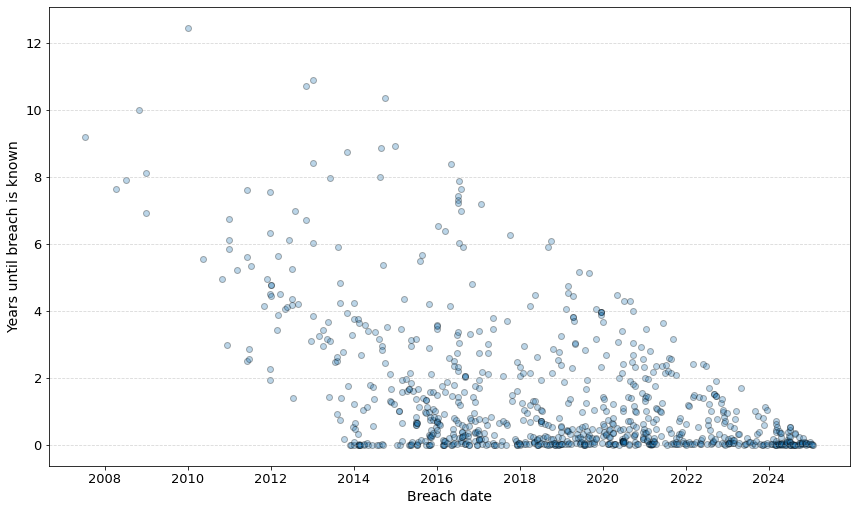

In [22]:
# plot
_scale = 1.2
_aspect_ratio = (10, 6)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

plt.scatter(df["breachdate"], df["yearstopublic"], alpha=0.3, edgecolor="black")
# plt.title("Years until breach is known", fontsize=14)
plt.xlabel("Breach date", fontsize=14)
plt.ylabel("Years until breach is known", fontsize=14)
ax.tick_params(axis="both", labelsize=13)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
save_mpl_fig("../figures/years_until_breach_known-breach_date")

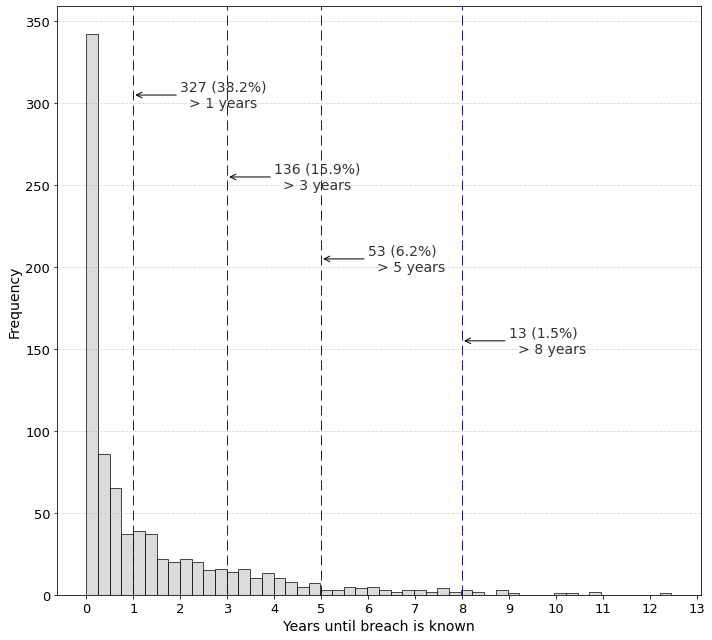

In [23]:
# plot
_scale = 1
_aspect_ratio = (10, 9)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

plt.hist(df["yearstopublic"], bins=50, edgecolor="black", color=".8", alpha=0.7)

# ==============================================================
# Values to annotate
thresholds = [1, 3, 5, 8]
y_loc_thresholds = {1: 305, 3: 255, 5: 205, 8: 155, 10: 155}
total_values = len(df)

for x in thresholds:
    # count
    count_above = (df["yearstopublic"] > x).sum()
    percent_above = (count_above / total_values) * 100

    # Add vertical line
    ax.axvline(x=x, color="navy", linestyle=(0, (10, 5)), linewidth=1, alpha=0.9)

    # Add text annotation
    ax.annotate(
        f"{count_above} ({percent_above:.1f}%)\n  > {x} years",
        color=".2",
        xy=(x, y_loc_thresholds[x]),  # Starting point of the arrow
        xytext=(x + 1, y_loc_thresholds[x]),  # Text position
        arrowprops=dict(facecolor="black", arrowstyle="->", lw=1),
        fontsize=14,
        ha="left",
        va="center",
    )

# ==============================================================
# plt.title("Histogram of Years to Public", fontsize=14)
plt.xlabel("Years until breach is known", fontsize=14)
ax.set_xticks(range(0, 14))
ax.tick_params(axis="both", labelsize=13)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
save_mpl_fig("../figures/years_until_breach_known")

## Breach size

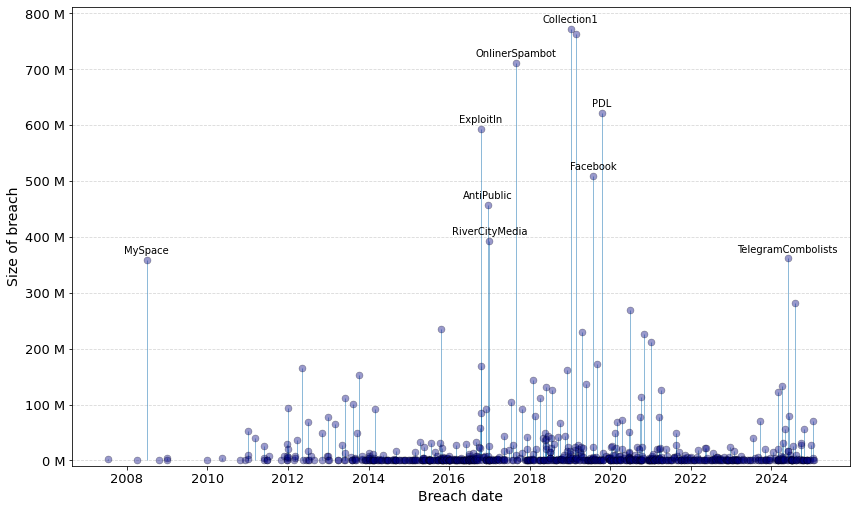

In [24]:
# plot
_scale = 1.2
_aspect_ratio = (10, 6)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

# ============================================================================
(markers, stemlines, baseline) = plt.stem(df["breachdate"], df["pwncount"], basefmt=" ")
plt.setp(
    markers,
    marker="o",
    color="navy",
    markersize=7,
    markeredgecolor="black",
    markeredgewidth=0.5,
    alpha=0.4,
)
plt.setp(stemlines, linewidth=0.5)
ax.set_ylim(ax.get_ylim()[0] / 4, ax.get_ylim()[1])

# ============================================================================
# Annotate
topx = df.nlargest(10, "pwncount")

# Adjust positions to avoid overlap
y_offsets = [20, -20, 30, -30, 40]  # Adjust vertical offset for each label
for i, (_, row) in enumerate(topx.iterrows()):
    if row["name"] == "VerificationsIO":
        continue
    ax.text(
        row["breachdate"],
        row["pwncount"] + 7_000_000,  # Position slightly above the point
        row["name"],
        fontsize=10,
        ha="center",
        va="bottom",
    )

# ============================================================================


def millions_formatter(x, pos):
    return f"{x / 1_000_000:,.0f} M"  # Format with commas and "million"


ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

# ============================================================================
plt.xlabel("Breach date", fontsize=14)
plt.ylabel("Size of breach", fontsize=14)
ax.tick_params(axis="both", labelsize=13)
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
save_mpl_fig("../figures/breachsize-breach_date")

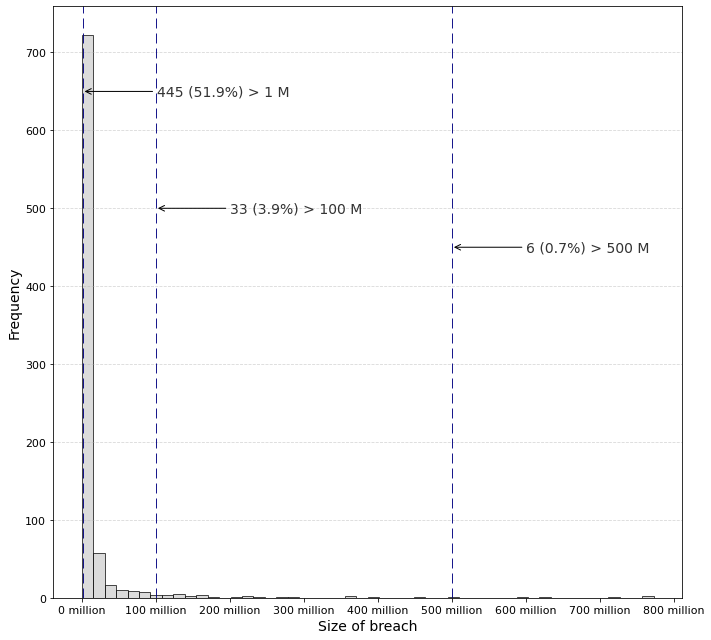

In [25]:
# plot
_scale = 1
_aspect_ratio = (10, 9)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

plt.hist(df["pwncount"], bins=50, edgecolor="black", color=".8", alpha=0.7)
# plt.title("Histogram of breach size", fontsize=14)
plt.xlabel("Size of breach", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# ==============================================================
# Values to annotate
thresholds = [1_000_000, 100_000_000, 500_000_000]
y_loc_thresholds = {
    1_000_000: 650,
    100_000_000: 500,
    500_000_000: 450,
}
total_values = len(df)

for x in thresholds:
    # count
    count_above = (df["pwncount"] > x).sum()
    percent_above = (count_above / total_values) * 100

    # Add vertical line
    ax.axvline(x=x, color="navy", linestyle=(0, (10, 5)), linewidth=1, alpha=0.9)

    # Add text annotation
    ax.annotate(
        f"{count_above} ({percent_above:.1f}%) > {int(x/1_000_000)} M",
        color=".2",
        xy=(x, y_loc_thresholds[x]),  # Starting point of the arrow
        xytext=(x + 1 * 100_000_000, y_loc_thresholds[x]),  # Text position
        arrowprops=dict(facecolor="black", arrowstyle="->", lw=1),
        fontsize=14,
        ha="left",
        va="center",
    )

# ==============================================================
# Adjust y-axis ticks to show as "X million"


def millions_formatter(x, pos):
    return f"{x / 1_000_000:,.0f} million"


plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(millions_formatter))

# ==============================================================
# plt.title("Histogram of breach size", fontsize=14)
plt.xlabel("Size of breach", fontsize=14)
ax.tick_params(axis="both", labelsize=11)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
save_mpl_fig("../figures/breachsize")

## Combine plots

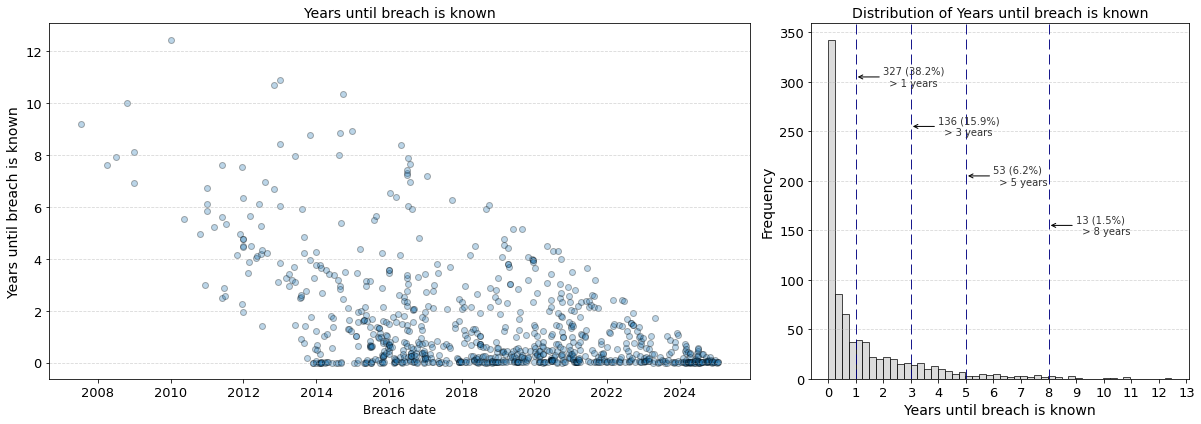

In [26]:
# plot
_scale = 1.2
_aspect_ratio = (14, 5)
figsize = tuple(k * _scale for k in _aspect_ratio)

# Create a figure with GridSpec for layout
fig = plt.figure(figsize=figsize)
gs = GridSpec(1, 2, width_ratios=[65, 35])  # Allocate 65% and 35% space

# ============================================================================
# Scatter Plot (65%)
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(df["breachdate"], df["yearstopublic"], alpha=0.3, edgecolor="black")
ax1.set_title("Years until breach is known", fontsize=14)
ax1.set_xlabel("Breach date", fontsize=12)
ax1.set_ylabel("Years until breach is known", fontsize=14)
ax1.tick_params(axis="both", labelsize=13)
ax1.grid(axis="y", linestyle="--", alpha=0.5)

# ============================================================================
# Histogram (35%)
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(df["yearstopublic"], bins=50, edgecolor="black", color=".8", alpha=0.7)

# Threshold annotations
thresholds = [1, 3, 5, 8]
y_loc_thresholds = {1: 305, 3: 255, 5: 205, 8: 155}
total_values = len(df)

for x in thresholds:
    count_above = (df["yearstopublic"] > x).sum()
    percent_above = (count_above / total_values) * 100

    # Add vertical line
    ax2.axvline(x=x, color="navy", linestyle=(0, (10, 5)), linewidth=1, alpha=0.9)

    # Add text annotation
    ax2.annotate(
        f"{count_above} ({percent_above:.1f}%)\n  > {x} years",
        color=".2",
        xy=(x, y_loc_thresholds[x]),
        xytext=(x + 1, y_loc_thresholds[x]),
        arrowprops=dict(facecolor="black", arrowstyle="->", lw=1),
        fontsize=10,
        ha="left",
        va="center",
    )

# Titles and labels for the histogram
ax2.set_title("Distribution of Years until breach is known", fontsize=14)
ax2.set_xlabel("Years until breach is known", fontsize=14)
ax2.set_xticks(range(0, 14))
ax2.tick_params(axis="both", labelsize=13)
ax2.set_ylabel("Frequency", fontsize=14)
ax2.grid(axis="y", linestyle="--", alpha=0.5)

# ============================================================================
plt.tight_layout()
save_mpl_fig("../figures/breach_summary-years_until_breach_known")

In [ ]:
# plot
_scale = 1.2
_aspect_ratio = (14, 8)
figsize = tuple(k * _scale for k in _aspect_ratio)

# Create a figure with GridSpec for layout
fig = plt.figure(figsize=figsize)
gs = GridSpec(
    2, 2, height_ratios=[1, 1], width_ratios=[65, 35]
)  # Equal height for both rows

TITLE_OPTS = dict(fontsize=15, loc="left", fontweight="bold")

# ============================================================================
# A
# ============================================================================
# Scatter Plot (65%)
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(df["breachdate"], df["yearstopublic"], alpha=0.3, edgecolor="black")
ax1.set_title("A. Years until breach is known and Breach date", **TITLE_OPTS)
ax1.set_xlabel("Breach date", fontsize=12)
ax1.set_ylabel("Years until breach is known", fontsize=14)
ax1.tick_params(axis="both", labelsize=13)
ax1.grid(axis="y", linestyle="--", alpha=0.5)

# ============================================================================
# B
# ============================================================================# Histogram (35%)
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(df["yearstopublic"], bins=50, edgecolor="black", color=".8", alpha=0.7)

# Threshold annotations
thresholds = [1, 3, 5, 8]
y_loc_thresholds = {1: 305, 3: 255, 5: 205, 8: 155}
total_values = len(df)

for x in thresholds:
    count_above = (df["yearstopublic"] > x).sum()
    percent_above = (count_above / total_values) * 100

    # Add vertical line
    ax2.axvline(x=x, color="navy", linestyle=(0, (10, 5)), linewidth=1, alpha=0.9)

    # Add text annotation
    ax2.annotate(
        f"{count_above} ({percent_above:.1f}%)\n  > {x} years",
        color=".2",
        xy=(x, y_loc_thresholds[x]),
        xytext=(x + 1, y_loc_thresholds[x]),
        arrowprops=dict(facecolor="black", arrowstyle="->", lw=1),
        fontsize=10,
        ha="left",
        va="center",
    )

# Titles and labels for the histogram
ax2.set_title("B. Years until breach is known", **TITLE_OPTS)
ax2.set_xlabel("Years until breach is known", fontsize=14)
ax2.set_xticks(range(0, 14))
ax2.tick_params(axis="both", labelsize=13)
ax2.set_ylabel("Frequency", fontsize=14)
ax2.grid(axis="y", linestyle="--", alpha=0.5)

# ============================================================================
# C
# ============================================================================
ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)  # Share x-axis with scatter plot
(markers, stemlines, baseline) = ax3.stem(df["breachdate"], df["pwncount"], basefmt=" ")
plt.setp(
    markers,
    marker="o",
    color="navy",
    markersize=6,
    markeredgecolor="black",
    markeredgewidth=0.5,
    alpha=0.4,
)
plt.setp(stemlines, linewidth=0.5)
ax3.set_ylim(ax3.get_ylim()[0] / 4, ax3.get_ylim()[1])

# Annotate the stem plot
topx = df.nlargest(10, "pwncount")
for _, row in topx.iterrows():
    if row["name"] == "VerificationsIO":
        continue
    ax3.text(
        row["breachdate"],
        row["pwncount"] + 7_000_000,
        row["name"],
        fontsize=10,
        ha="center",
        va="bottom",
    )

# Format y-axis to show millions


def millions_formatter(x, pos):
    return f"{x / 1_000_000:,.0f} M"


ax3.set_title("C. Size of breach and Breach date", **TITLE_OPTS)
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
ax3.set_xlabel("Breach date", fontsize=14)
ax3.set_ylabel("Size of breach", fontsize=14)
ax3.tick_params(axis="both", labelsize=13)
ax3.grid(axis="y", linestyle="--", alpha=0.5)

# ============================================================================
# D
# ============================================================================
ax4 = fig.add_subplot(gs[1, 1])
plt.hist(df["pwncount"], bins=50, edgecolor="black", color=".8", alpha=0.7)
# plt.title("Histogram of breach size", fontsize=14)
plt.xlabel("Size of breach and Breach date", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# ==============================================================
# Values to annotate
thresholds = [1_000_000, 100_000_000, 500_000_000]
y_loc_thresholds = {
    1_000_000: 650,
    100_000_000: 500,
    500_000_000: 450,
}
total_values = len(df)

for x in thresholds:
    # count
    count_above = (df["pwncount"] > x).sum()
    percent_above = (count_above / total_values) * 100

    # Add vertical line
    ax4.axvline(x=x, color="navy", linestyle=(0, (10, 5)), linewidth=1, alpha=0.9)

    # Add text annotation
    ax4.annotate(
        f"{count_above} ({percent_above:.1f}%) > {int(x/1_000_000)} M",
        color=".2",
        xy=(x, y_loc_thresholds[x]),  # Starting point of the arrow
        xytext=(x + 1 * 100_000_000, y_loc_thresholds[x]),  # Text position
        arrowprops=dict(facecolor="black", arrowstyle="->", lw=1),
        fontsize=11,
        ha="left",
        va="center",
    )

# ==============================================================
# Adjust y-axis ticks to show as "X million"


def millions_formatter(x, pos):
    return f"{x / 1_000_000:,.0f}M"


plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(millions_formatter))

# ==============================================================
plt.title("D. Size of breach", **TITLE_OPTS)
plt.xlabel("Size of breach", fontsize=14)
ax4.tick_params(axis="both", labelsize=11)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# ============================================================================
plt.tight_layout()
save_mpl_fig("../figures/breach_summary-years_until_breach_known-breach_size")